In [1]:
import re
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
import numpy as np

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter("ignore")

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load the dataset

In [3]:
data = open("dow_jones_index.data").read()

FileNotFoundError: [Errno 2] No such file or directory: 'dow_jones_index.data'

In [4]:
data = re.split('\n',data)

NameError: name 'data' is not defined

In [197]:
quarter = []
stock = []
date = [] 
Open = []
high = []
low = []
close = []
volume = []
percent_change_price = []
percent_change_volume_over_last_wk = []
previous_weeks_volume = []
next_weeks_open = []
next_weeks_close = []
percent_change_next_weeks_price = []
days_to_next_dividend = []
percent_return_next_dividend = []

In [198]:
for i in range(1,len(data)-1):
    quarter.append(data[i].split(',')[0])
    stock.append(data[i].split(',')[1])
    date.append(data[i].split(',')[2]) 
    Open.append(data[i].split(',')[3])
    high.append(data[i].split(',')[4])
    low.append(data[i].split(',')[5])
    close.append(data[i].split(',')[6])
    volume.append(data[i].split(',')[7])
    percent_change_price.append(data[i].split(',')[8])
    percent_change_volume_over_last_wk.append(data[i].split(',')[9])
    previous_weeks_volume.append(data[i].split(',')[10])
    next_weeks_open.append(data[i].split(',')[11])
    next_weeks_close.append(data[i].split(',')[12])
    percent_change_next_weeks_price.append(data[i].split(',')[13])
    days_to_next_dividend.append(data[i].split(',')[14])
    percent_return_next_dividend.append(data[i].split(',')[15])

### Create a dataframe

In [199]:
df = pd.DataFrame()
df['quarter'] = quarter
df['stock'] = stock
df['date'] = date
df['Open'] = Open
df['high'] = high
df['low'] = low
df['close'] = close
df['volume'] = volume
df['percent_change_price'] = percent_change_price
df['percent_change_volume_over_last_wk'] = percent_change_volume_over_last_wk
df['previous_weeks_volume'] = previous_weeks_volume
df['next_weeks_open'] = next_weeks_open
df['next_weeks_close'] = next_weeks_close
df['percent_change_next_weeks_price'] = percent_change_next_weeks_price
df['days_to_next_dividend'] = days_to_next_dividend
df['percent_return_next_dividend'] = percent_return_next_dividend

In [200]:
# Set date as index
df.set_index('date', inplace=True)

In [201]:
df.head()

,quarter,stock,Open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,,
1/7/2011,1,AA,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,,,$16.71,$15.97,-4.42849,26,0.182704
1/14/2011,1,AA,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223028,239655616,$16.19,$15.79,-2.47066,19,0.187852
1/21/2011,1,AA,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.02495926,242963398,$15.87,$16.13,1.63831,12,0.189994
1/28/2011,1,AA,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500109,138428495,$16.18,$17.14,5.93325,5,0.185989
2/4/2011,1,AA,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987451735,151379173,$17.33,$17.37,0.230814,97,0.175029


In the above table, some relations among the columns of the table can be seen.

Eg. 
- percent_change_price is the percent change in price from 'Open' column and 'close' column.

- percent_change_next_weeks_price is the percent change in price from 'next_weeks_open' column and 'next_weeks_close' column

- percent_change_volume_over_last_wk is the percent change in volume from 'volume' column and 'previous_weeks_volume' column

And I observe that the data for percent_change_volume_over_last_wk is missing when data for previous_weeks_volume is missing.

#### Remove the dollar signs

In [202]:
df['Open'] = df['Open'].str.replace('$', '')
df['high'] = df['high'].str.replace('$', '')
df['low'] = df['low'].str.replace('$', '')
df['close'] = df['close'].str.replace('$', '')
df['next_weeks_open'] = df['next_weeks_open'].str.replace('$', '')
df['next_weeks_close'] = df['next_weeks_close'].str.replace('$', '')

In [203]:
df.head()

,quarter,stock,Open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,,
1/7/2011,1,AA,15.82,16.72,15.78,16.42,239655616,3.79267,,,16.71,15.97,-4.42849,26,0.182704
1/14/2011,1,AA,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223028,239655616,16.19,15.79,-2.47066,19,0.187852
1/21/2011,1,AA,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.02495926,242963398,15.87,16.13,1.63831,12,0.189994
1/28/2011,1,AA,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500109,138428495,16.18,17.14,5.93325,5,0.185989
2/4/2011,1,AA,16.18,17.39,16.18,17.14,154387761,5.93325,1.987451735,151379173,17.33,17.37,0.230814,97,0.175029


### Data Exploration

In [99]:
df.shape

(750, 16)

The dataset has 750 rows and 16 attributes.

In [205]:
df['percent_change_price'] = pd.to_numeric(df['percent_change_price'])
df['Price Direction'] = np.where(df['percent_change_price'] > 0, 1, 0)

#### Added a new column Price Direction according to the sign of percent_price_change. 1 means stock rise and 0 means stock fall.

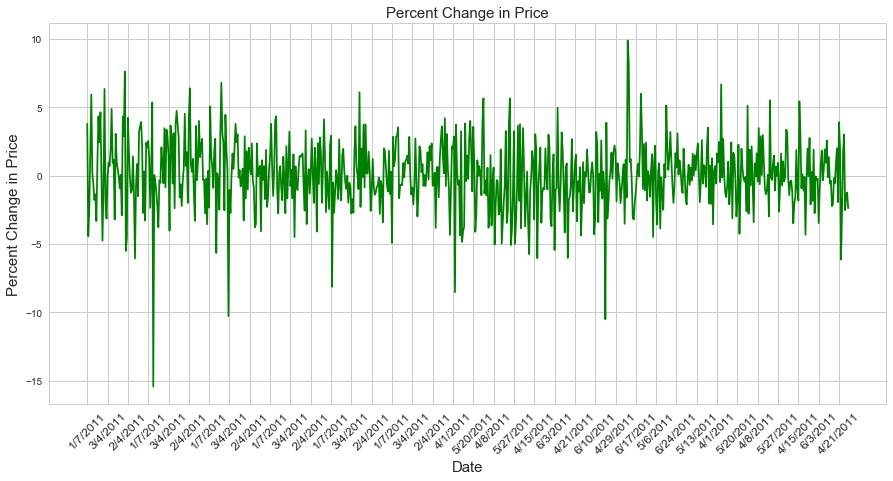

In [123]:
plt.figure(figsize = (15,7))
plt.plot(range(df.shape[0]),df['percent_change_price'],'g')
plt.xticks(range(0,df.shape[0],20),df.index[::20],rotation=45,fontsize = 12)
plt.title('Percent Change in Price',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Percent Change in Price',fontsize=15)
plt.show()

#### The price is changing quite frequently over the time. It can be seen that it fell badly during quarter 1 as compared to quarter 2.

In [208]:
df['percent_change_next_weeks_price'] = pd.to_numeric(df['percent_change_next_weeks_price'])
df['Price Direction Next Week'] = np.where(df['percent_change_next_weeks_price'] > 0, 1, 0)

#### Added a new column Price Direction Next Week according to the sign of percent_change_next_weeks_price. 1 means stock rise and 0 means stock fall.

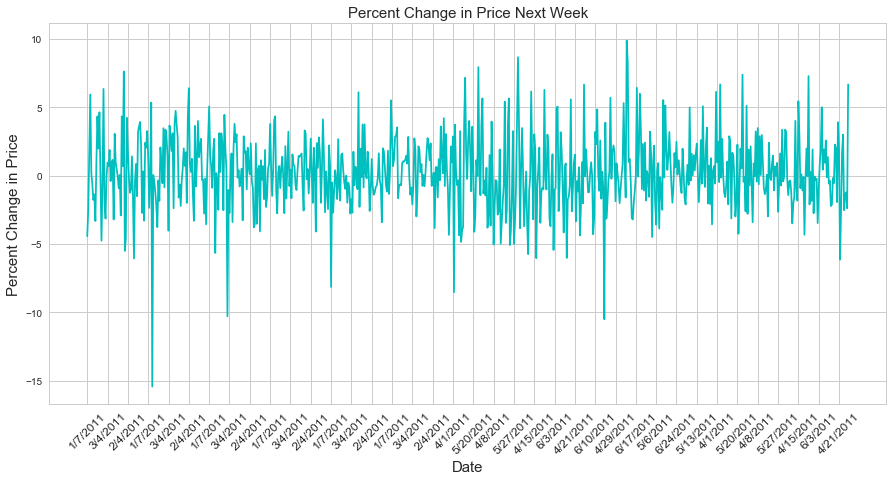

In [125]:
plt.figure(figsize = (15,7))
plt.plot(range(df.shape[0]),df['percent_change_next_weeks_price'],'c')
plt.xticks(range(0,df.shape[0],20),df.index[::20],rotation=45,fontsize = 12)
plt.title('Percent Change in Price Next Week',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Percent Change in Price',fontsize=15)
plt.show()

#### Almost same pattern can be as seen above for the change in price for next week.

In [235]:
df.head()

,quarter,stock,Open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,Price Direction,Price Direction Next Week
date,,,,,,,,,,,,,,,,,
1/7/2011,1,AA,15.82,16.72,15.78,16.42,239655616,3.79267,,,16.71,15.97,-4.428490,26,0.182704,1,0
1/14/2011,1,AA,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223028,239655616,16.19,15.79,-2.470660,19,0.187852,0,0
1/21/2011,1,AA,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.02495926,242963398,15.87,16.13,1.638310,12,0.189994,0,1
1/28/2011,1,AA,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500109,138428495,16.18,17.14,5.933250,5,0.185989,1,1
2/4/2011,1,AA,16.18,17.39,16.18,17.14,154387761,5.93325,1.987451735,151379173,17.33,17.37,0.230814,97,0.175029,1,1


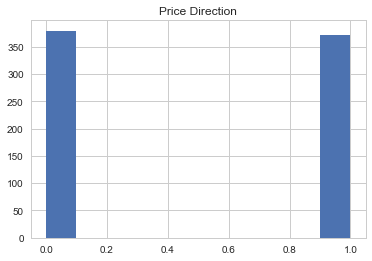

In [221]:
df.hist(column = 'Price Direction')
plt.show()

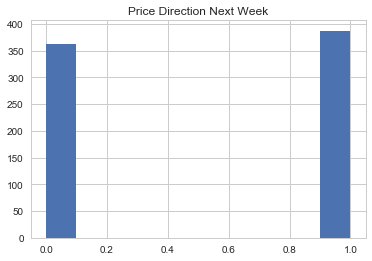

In [222]:
df.hist(column = 'Price Direction Next Week')
plt.show()

#### The data for price direction and price direction next week are almost equally distributed

### Clustering

In [163]:
X = df['percent_change_price'].values.reshape(-1,1)
X = np.asarray(X)

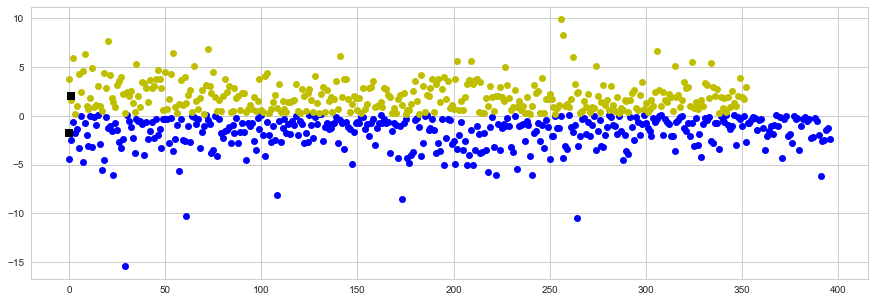

In [260]:
# computing K-Means with K = 5 (5 clusters)
centroids,_ = kmeans(X,2)
# assign each sample to a cluster
idx,_ = vq(X,centroids)
 
# some plotting using numpy's logical indexing

plt.figure(figsize=(15, 5))
plt.plot(X[idx==0],'ob',
     X[idx==1],'oy')
plt.plot(centroids,'sk',markersize=8)
plt.show()

Before proceeding towards classification, 2 columns need to be removed from the data frame as they have missing values - percent_change_volume_over_last_wk	and previous_weeks_volume

In [274]:
df = df[['quarter', 'Open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend', 'Price Direction',
       'Price Direction Next Week']]

Quarter 1 data is taken as training data and Quarter 2 data is taken as test data.

In [297]:
train_data = df[df['quarter'].astype(int) == 1]
X_train = train_data.iloc[:,0:11]
Y_train = train_data['Price Direction']

In [298]:
test_data = df[df['quarter'].astype(int) == 2]
X_test = test_data.iloc[:,0:11]
Y_test = test_data['Price Direction']

### Logistic Regression Classifier

Logistic regression falls under the category of supervised learning; it measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. It is a classification problem which is used to predict a binary outcome (1/0, -1/1, True/False) given a set of independent variables.

In [316]:
# Fit the logistic regression model
clf = LogisticRegression()
clf = clf.fit(X_train, Y_train)

# predict the class labels using predict function for the test dataset
y_pred_lr = clf.predict(X_test)

n_errors = (y_pred_lr != Y_test).sum()

# Run classification metrics
print('{}: {}'.format('Logistic Regression', n_errors))
print('Accuracy: ', accuracy_score(Y_test, y_pred_lr))
print(classification_report(Y_test, y_pred_lr))
print('AUC Score: ', roc_auc_score(Y_test, y_pred_lr))
print("\n Confustion matrix on test data: \n" + str(confusion_matrix(Y_test, y_pred_lr)))

Logistic Regression: 175
Accuracy:  0.5512820512820513
             precision    recall  f1-score   support

          0       0.55      1.00      0.71       215
          1       0.00      0.00      0.00       175

avg / total       0.30      0.55      0.39       390

AUC Score:  0.5

 Confustion matrix on test data: 
[[215   0]
 [175   0]]


The f1-score tells you the accuracy of the classifier in classifying the data points in that particular class compared to all other class. It is calculated by taking the harmonic mean of precision and recall. The support is the number of samples of the true response that lies in that class.

Here, the accuracy is 55%, which is quite low. Also the number of misinterpretations is 175. 

### Naive Bayes Classifier

The Naive Bayes algorithm is an intuitive method that uses the probabilities of each attribute belonging to each class to make a prediction. It simplifies the calculation of probabilities by assuming that the probability of each attribute belonging to a given class value is independent of all other attributes. This is a strong assumption but results in a fast and effective method.

In [317]:
# Fit the Naive Bayes model
clf = GaussianNB()
clf.fit(X_train, Y_train)
y_pred_nb = clf.predict(X_test)

n_errors = (y_pred_nb != Y_test).sum()

# Run classification metrics
print('{}: {}'.format('Naive Bayes', n_errors))
print('Accuracy: ',accuracy_score(Y_test, y_pred_nb))
print(classification_report(Y_test, y_pred_nb))
print('AUC Score: ',roc_auc_score(Y_test, y_pred_nb))

Naive Bayes: 204
Accuracy:  0.47692307692307695
             precision    recall  f1-score   support

          0       0.66      0.11      0.18       215
          1       0.46      0.93      0.62       175

avg / total       0.57      0.48      0.38       390

AUC Score:  0.519202657807309


However, in this case it seems failing as number of misinterpretations is 204 and accuracy is also lower than logistic regression, 47%.

### Random Forest Classifier 

A random forest model is an ensemble of classification (or regression) trees. Ensembles perform well when individual members are dissimilar, and random forests obtain variation among individual trees using two sources for randomness: first, each tree is built on separate bootstrapped samples of the training data; secondly, only a randomly selected subset of data attributes is considered at each node in building the individual trees. Random forests thus combine the concepts of bagging, where individual models in an ensemble are developed through sampling with replacement from the training data, and the random subspace method, where each tree in an ensemble is built from a random subset of attributes. 

In [305]:
# Fit the RandomForest Classifier
clf = RandomForestClassifier()
clf = clf.fit(X_train, Y_train)

y_pred_rf = clf.predict(X_test)

n_errors = (y_pred_rf != Y_test).sum()
    
# Run classification metrics
print('{}: {}'.format('Random Forest', n_errors))
print('Accuracy: ',accuracy_score(Y_test, y_pred_rf))
print(classification_report(Y_test, y_pred_rf))
print('AUC Score: ',roc_auc_score(Y_test, y_pred_rf))
print("\n Confustion matrix on test data: \n" + str(confusion_matrix(Y_test, y_pred_rf)))

Random Forest: 0
1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       215
          1       1.00      1.00      1.00       175

avg / total       1.00      1.00      1.00       390

1.0

 Confustion matrix on test data: 
[[215   0]
 [  0 175]]


Random Forest worked pretty well results as compared to other classification algorithms.